In [1]:
%matplotlib inline
import sys 
sys.path.append('../../../')
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import gpflow, gpitch
reload(gpitch)
from gpitch.amtgp import logistic
from scipy.fftpack import fft, ifft, ifftshift

In [2]:
gpitch.amtgp.init_settings()
plt.rcParams['figure.figsize'] = (16, 3)  # set plot size

In [3]:
#np.random.seed(29)
Nc = 5  # number of partials
var = 0.25*np.random.rand(Nc)  # variances
leng = 0.5*np.random.rand()  # lengthscales
f0 = 1000*np.random.rand()
freq = f0*np.asarray(range(1, Nc+ 1)) + np.sqrt(100.)*np.random.randn(Nc) # frequencies
kern1 = gpitch.kernels.MaternSpecMixSL(input_dim=1, lengthscales=leng, variances=var, frequencies=freq)
kern2 = gpflow.kernels.Matern32(input_dim=1, lengthscales=0.025, variance=10.)

In [4]:
f0*np.asarray(range(1, Nc+ 1))

array([  723.40786413,  1446.81572827,  2170.2235924 ,  2893.63145653,
        3617.03932066])

In [5]:
print freq
print leng
print var

[  721.14904049  1440.74870158  2160.88759436  2889.74345941  3615.63962275]
0.246601840764
[ 0.18206179  0.07378936  0.15209119  0.04935975  0.03808094]


In [6]:
N, fs = 1600, 16e3
x = np.linspace(0., (N-1.)/fs, N).reshape(-1, 1)
Kcom = kern1.compute_K_symm(x)
Kact = kern2.compute_K_symm(x)

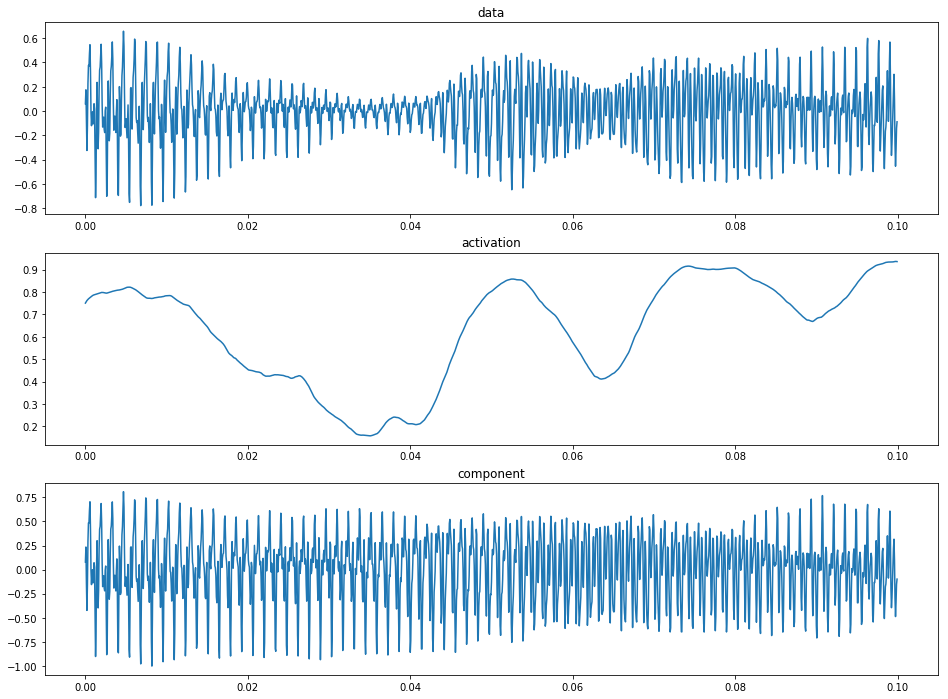

In [7]:
noise_var = 1e-5
com = np.random.multivariate_normal(np.zeros((N)), Kcom, 1).reshape(-1, 1)
com /= np.max(np.abs(com))
g = np.random.multivariate_normal(np.zeros((N)), Kact, 1).reshape(-1, 1)
act = logistic(g)
y = act*com + np.sqrt(noise_var)*np.random.randn(N,1)

plt.figure(figsize=(16, 12))
plt.subplot(3,1,1), plt.title('data')
plt.plot(x, y)
plt.subplot(3,1,2), plt.title('activation')
plt.plot(x, act)
plt.subplot(3,1,3), plt.title('component')
plt.plot(x, com)

# New component covariance function

In [8]:
params, Y, S, F = gpitch.amtgp.init_com_params(y=y, fs=fs, Nh=Nc, scaled=True)
print params[2]
print params[1]
print params[0]

[[  720.90112625]
 [ 2160.92863559]
 [ 3621.09437328]
 [ 2893.61702139]
 [ 1441.80225278]]
[[ 0.6737727 ]
 [ 0.02325825]
 [ 0.00756212]
 [ 0.62393426]
 [ 0.6200573 ]]
[[ 0.00431424]
 [ 0.12607628]
 [ 0.11705273]
 [ 0.00136658]
 [ 0.00119018]]


In [9]:
kern1

Name,values,prior,constraint
unnamed.frequency_1,[ 721.14904049],None,+ve
unnamed.frequency_2,[ 1440.74870158],None,+ve
unnamed.frequency_3,[ 2160.88759436],None,+ve
unnamed.frequency_4,[ 2889.74345941],None,+ve
unnamed.frequency_5,[ 3615.63962275],None,+ve
unnamed.lengthscales,[ 0.24660184],None,+ve
unnamed.variance_1,[ 0.18206179],None,+ve
unnamed.variance_2,[ 0.07378936],None,+ve
unnamed.variance_3,[ 0.15209119],None,+ve
unnamed.variance_4,[ 0.04935975],None,+ve


In [10]:
kern2

Name,values,prior,constraint
unnamed.lengthscales,[ 0.025],None,+ve
unnamed.variance,[ 10.],None,+ve


In [11]:
kern_com = gpitch.kernels.MaternSpecMixSL(input_dim=1, ideal_f0=f0, Nc=Nc)
kern_act = gpflow.kernels.Matern32(1)

In [12]:
ws, dec = N//1, 80  # samples per window, decimation factor
m = gpitch.modpdet.ModPDet(x=x, y=y, kern_com=kern_com, kern_act=kern_act, ws=ws, dec=dec, whiten=True)
m.model.kern1.fixed = False
m.model.kern2.fixed = False
m.model.likelihood.noise_var.fixed = False

In [13]:
maxiter, restarts = 500, 5
init_hyper, learnt_hyper, mse = m.optimize_restart(maxiter=maxiter, restarts=restarts)

| len: 0.24414230, 0.04770087 | sig: 1.23768640, 3.57936906 | noise_var: 0.03263306, 0.00404660 |
| len: 0.90550713, 0.11291192 | sig: 13.96257408, 13.79587543 | noise_var: 0.01916782, 0.00443827 |
| len: 0.73828971, 0.06580613 | sig: 6.56797736, 5.83992683 | noise_var: 0.09439997, 0.00403516 |
| len: 0.75894555, 0.13522260 | sig: 14.88174513, 14.63031305 | noise_var: 0.01923661, 0.00461475 |
| len: 0.07958848, 0.10351582 | sig: 9.64898399, 8.68353885 | noise_var: 0.08138049, 0.00446873 |


In [14]:
m.model.kern2.lengthscales = learnt_hyper[0].mean().copy()
m.model.kern2.variance = learnt_hyper[1].mean().copy()
m.model.likelihood.noise_var = learnt_hyper[2].mean().copy()

In [15]:
#m.model.kern2

In [16]:
#m.model.kern1

In [17]:
#print m.model.likelihood.noise_var

In [18]:
m.optimize_windowed(disp=1, maxiter=1000)

In [19]:
print freq
print leng
print var

[  721.14904049  1440.74870158  2160.88759436  2889.74345941  3615.63962275]
0.246601840764
[ 0.18206179  0.07378936  0.15209119  0.04935975  0.03808094]


In [20]:
m.model.kern1

Name,values,prior,constraint
kern1.frequency_1,[ 721.9787834],None,+ve
kern1.frequency_2,[ 1446.02707351],None,+ve
kern1.frequency_3,[ 2159.87594828],None,+ve
kern1.frequency_4,[ 2888.69299348],None,+ve
kern1.frequency_5,[ 3614.8380188],None,+ve
kern1.lengthscales,[ 0.09996271],None,"[0.0, 0.1]"
kern1.variance_1,[ 0.18708191],None,"[0.0, 0.25]"
kern1.variance_2,[ 0.02101184],None,"[0.0, 0.25]"
kern1.variance_3,[ 0.24028882],None,"[0.0, 0.25]"
kern1.variance_4,[ 0.09595596],None,"[0.0, 0.25]"


In [21]:
m.model.kern2

Name,values,prior,constraint
kern2.lengthscales,[ 0.06318895],None,+ve
kern2.variance,[ 9.03909834],None,+ve


In [22]:
print m.model.likelihood.noise_var

noise_var transform:[0.0, 0.1] prior:None
[ 0.0040375]


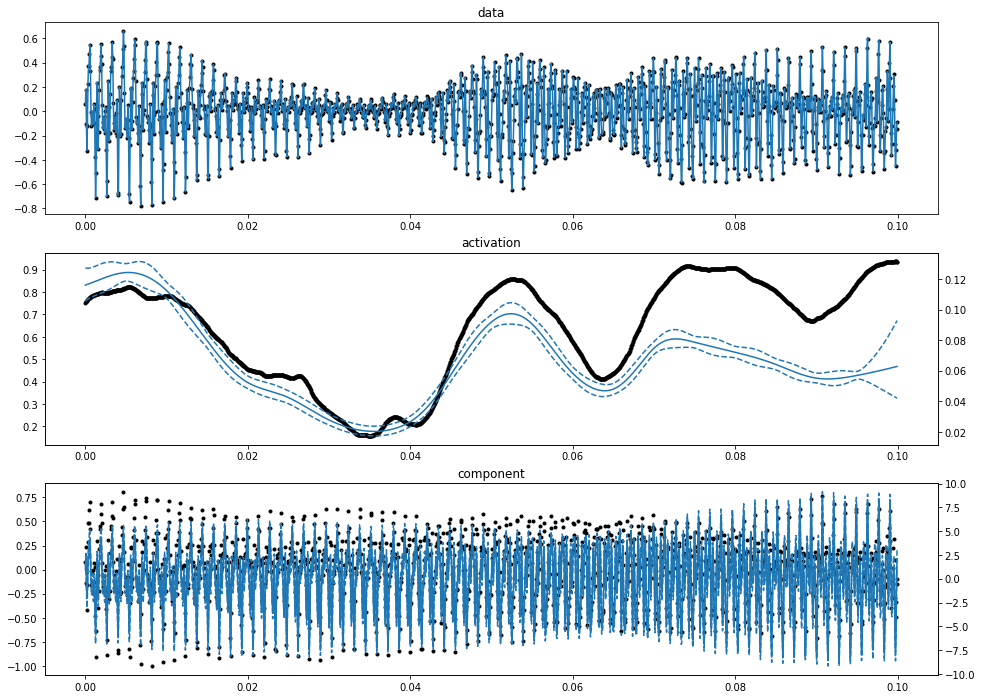

In [23]:
mean_f, var_f = m.model.predict_f(x)
mean_g, var_g = m.model.predict_g(x)
mean_act = logistic(mean_g)

plt.figure(figsize=(16, 12))
plt.subplot(3,1,1)
plt.plot(x, y, '.k'), plt.title('data')
plt.plot(x, act*com)

plt.subplot(3,1,2)
plt.plot(x, act, '.k'), plt.title('activation')
plt.twinx()
plt.plot(x, mean_act)
plt.plot(x, logistic(mean_g + 2.*np.sqrt(var_g)), '--C0')
plt.plot(x, logistic(mean_g - 2.*np.sqrt(var_g)), '--C0')

plt.subplot(3,1,3)
plt.plot(x, com, '.k'), plt.title('component')
plt.twinx()
plt.plot(x, mean_f)
plt.plot(x, mean_f + 2.*np.sqrt(var_f), '--C0')
plt.plot(x, mean_f - 2.*np.sqrt(var_f), '--C0')

In [24]:
# plt.figure(figsize=(16, 12))
# plt.subplot(3,1,1)
# plt.plot(x, y, '.k'), plt.title('data')
# plt.plot(x, logistic(m.qm2)*m.qm1)

# plt.subplot(3,1,2)
# plt.plot(x, act, '.k'), plt.title('activation')
# plt.plot(x, logistic(m.qm2))

# plt.subplot(3,1,3)
# plt.plot(x, com, '.k'), plt.title('component')
# plt.plot(x, m.qm1)